<a href="https://colab.research.google.com/github/guptasim8/Thesis-Related/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
tfds.disable_progress_bar()

In [2]:
tf.__version__

'2.8.2'

In [3]:
devices = tf.config.experimental.list_physical_devices('GPU')
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(devices[0], True)
    print("Success")
except:
    print("Exception occured")
    pass

Success


In [5]:
dataset, info = tfds.load('imdb_reviews', data_dir='.', with_info=True, as_supervised=True)

Shuffling and writing examples to ./imdb_reviews/plain_text/1.0.0.incompleteO8NZQT/imdb_reviews-train.tfrecord
Shuffling and writing examples to ./imdb_reviews/plain_text/1.0.0.incompleteO8NZQT/imdb_reviews-test.tfrecord
Shuffling and writing examples to ./imdb_reviews/plain_text/1.0.0.incompleteO8NZQT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to ./imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [7]:
dataset

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'unsupervised': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [8]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [9]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [10]:
len(train_dataset)

25000

In [11]:
len(test_dataset)

25000

In [12]:
for sample in train_dataset:
    print(sample[0].numpy())
    break

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"Well - when the cameo appearance of Jason Miller (looking even more eroded than he did in Exorcist IV) is the high point of a picture, what've you got?<br /><br />It's a little bit country, a little bit rock n' roll: mix two drunks with money who drag their kid all over the place with a bog-dried mummy (have you figured that one out yet - DRIED in a bog?) in the basement, Christopher Walken with a bad dye job, and a little girl who might have been an interesting character if they'd developed her.<br /><br />I understand - sort of - that they're going back to visit her relatives. After that....<br /><br />Problem: There are several interesting flashbacks to what I must assume is her mother being killed in a car bombing (I think). This is never connected to anything. <br /><br />Problem: What do we need the grandmother for? Now, the grandmother could be interesting. She speaks Gaelic, or Celtic, or something. Maybe you can make something of her. The best they can do is that sh

In [16]:
e = tf.keras.layers.experimental.preprocessing.TextVectorization()
e.adapt([
    "I love samosas and jalebi",
    "I love biking and yoga",
    "I love tensorflow"
])

In [17]:
e.get_vocabulary()

['',
 '[UNK]',
 'love',
 'i',
 'and',
 'yoga',
 'tensorflow',
 'samosas',
 'jalebi',
 'biking']

In [18]:
e(["I love pizza"]).numpy()

array([[3, 2, 1]])

In [19]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:25]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are'], dtype='<U14')

In [22]:
example[0]

<tf.Tensor: shape=(), dtype=string, numpy=b"Well - when the cameo appearance of Jason Miller (looking even more eroded than he did in Exorcist IV) is the high point of a picture, what've you got?<br /><br />It's a little bit country, a little bit rock n' roll: mix two drunks with money who drag their kid all over the place with a bog-dried mummy (have you figured that one out yet - DRIED in a bog?) in the basement, Christopher Walken with a bad dye job, and a little girl who might have been an interesting character if they'd developed her.<br /><br />I understand - sort of - that they're going back to visit her relatives. After that....<br /><br />Problem: There are several interesting flashbacks to what I must assume is her mother being killed in a car bombing (I think). This is never connected to anything. <br /><br />Problem: What do we need the grandmother for? Now, the grandmother could be interesting. She speaks Gaelic, or Celtic, or something. Maybe you can make something of her

In [23]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 74,  51,   2, ...,   0,   0,   0],
       [  4, 220,   5, ...,   0,   0,   0],
       [ 10, 237,   1, ...,   0,   0,   0]])

In [24]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b"Well - when the cameo appearance of Jason Miller (looking even more eroded than he did in Exorcist IV) is the high point of a picture, what've you got?<br /><br />It's a little bit country, a little bit rock n' roll: mix two drunks with money who drag their kid all over the place with a bog-dried mummy (have you figured that one out yet - DRIED in a bog?) in the basement, Christopher Walken with a bad dye job, and a little girl who might have been an interesting character if they'd developed her.<br /><br />I understand - sort of - that they're going back to visit her relatives. After that....<br /><br />Problem: There are several interesting flashbacks to what I must assume is her mother being killed in a car bombing (I think). This is never connected to anything. <br /><br />Problem: What do we need the grandmother for? Now, the grandmother could be interesting. She speaks Gaelic, or Celtic, or something. Maybe you can make something of her. The best they can do is that 

In [61]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [62]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text = ('awesome movie, I loved it so much')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.50071293]


In [64]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [65]:
model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 42s 90ms/step - loss: 0.6403 - accuracy: 0.6297 - val_loss: 0.4795 - val_accuracy: 0.7844
Epoch 2/5
391/391 [==============================] - 33s 83ms/step - loss: 0.4354 - accuracy: 0.8095 - val_loss: 0.3818 - val_accuracy: 0.8401
Epoch 3/5
391/391 [==============================] - 33s 83ms/step - loss: 0.3624 - accuracy: 0.8459 - val_loss: 0.3515 - val_accuracy: 0.8542
Epoch 4/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3306 - accuracy: 0.8620 - val_loss: 0.3312 - val_accuracy: 0.8594
Epoch 5/5
391/391 [==============================] - 33s 83ms/step - loss: 0.3181 - accuracy: 0.8674 - val_loss: 0.3352 - val_accuracy: 0.8583


In [66]:
model.evaluate(test_dataset)

391/391 [==============================] - 24s 61ms/step - loss: 0.3306 - accuracy: 0.8584


[0.33064761757850647, 0.8583599925041199]

In [83]:
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred>0.5)

In [84]:
y_pred_classes

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [81]:
y_test=[]
for example, label in test_dataset:
    y_test.extend(label.numpy())
y_test
len(y_test)

25000

In [74]:
y_pred

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [76]:
len(y_pred)

25000

Text(33.0, 0.5, 'Truth')

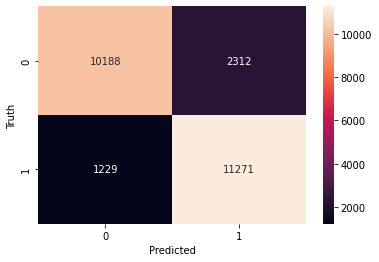

In [86]:
from matplotlib import pyplot as plt
import seaborn as sn
cm=confusion_matrix(y_test, y_pred_classes)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85     12500
           1       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

